# Black Friday Sales - Exploratory Data Analysis

This notebook performs exploratory data analysis on the Black Friday sales dataset to understand customer purchasing behavior and identify patterns.

In [1]:
# Import libraries
import sys
sys.path.append('..')

from config.spark_config import SparkConfig, DataPaths
from pyspark.sql import functions as F
from pyspark.sql.window import Window
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Set styling
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Initialize Spark Session
spark = SparkConfig.get_spark_session("BlackFriday-EDA")

print("\n✓ Libraries imported successfully!")
print("✓ Spark session initialized!")

✓ Windows: HADOOP_HOME set to C:\Users\usate\PycharmProjects\BlackFriday\hadoop
  Note: If you encounter permission errors, download winutils.exe
  from https://github.com/steveloughran/winutils and place in hadoop/bin/
Spark Session Created: BlackFriday-EDA
Spark Version: 3.5.3
Master: local[*]
App Name: BlackFriday-EDA

✓ Libraries imported successfully!
✓ Spark session initialized!


## 1. Load Data

In [2]:
# Load training and test data using PySpark
train_df = spark.read.csv('../data/raw/train.csv', header=True, inferSchema=True)
test_df = spark.read.csv('../data/raw/test.csv', header=True, inferSchema=True)

# Cache data for better performance
train_df.cache()
test_df.cache()

print(f"Training data shape: ({train_df.count()}, {len(train_df.columns)})")
print(f"Test data shape: ({test_df.count()}, {len(test_df.columns)})")
print("\nFirst few rows of training data:")
train_df.show(5, truncate=False)

Training data shape: (550068, 12)
Test data shape: (233599, 11)

First few rows of training data:
+-------+----------+------+----+----------+-------------+--------------------------+--------------+------------------+------------------+------------------+--------+
|User_ID|Product_ID|Gender|Age |Occupation|City_Category|Stay_In_Current_City_Years|Marital_Status|Product_Category_1|Product_Category_2|Product_Category_3|Purchase|
+-------+----------+------+----+----------+-------------+--------------------------+--------------+------------------+------------------+------------------+--------+
|1000001|P00069042 |F     |0-17|10        |A            |2                         |0             |3                 |NULL              |NULL              |8370    |
|1000001|P00248942 |F     |0-17|10        |A            |2                         |0             |1                 |6                 |14                |15200   |
|1000001|P00087842 |F     |0-17|10        |A            |2              

## 2. Podstawowe Informacje o Danych

In [3]:
# Informacje o strukturze danych
print("=" * 50)
print("INFORMACJE O ZBIORZE TRENINGOWYM")
print("=" * 50)
print(f"\nWymiary: {train_df.count():,} wierszy x {len(train_df.columns)} kolumn")
print(f"\nTypy danych:")
train_df.printSchema()

# Wyświetl przykładowe dane
print("\n" + "=" * 50)
print("Przykładowe dane:")
print("=" * 50)
train_df.show(10)

INFORMACJE O ZBIORZE TRENINGOWYM

Wymiary: 550,068 wierszy x 12 kolumn

Typy danych:
root
 |-- User_ID: integer (nullable = true)
 |-- Product_ID: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: string (nullable = true)
 |-- Occupation: integer (nullable = true)
 |-- City_Category: string (nullable = true)
 |-- Stay_In_Current_City_Years: string (nullable = true)
 |-- Marital_Status: integer (nullable = true)
 |-- Product_Category_1: integer (nullable = true)
 |-- Product_Category_2: integer (nullable = true)
 |-- Product_Category_3: integer (nullable = true)
 |-- Purchase: integer (nullable = true)


Przykładowe dane:
+-------+----------+------+-----+----------+-------------+--------------------------+--------------+------------------+------------------+------------------+--------+
|User_ID|Product_ID|Gender|  Age|Occupation|City_Category|Stay_In_Current_City_Years|Marital_Status|Product_Category_1|Product_Category_2|Product_Category_3|Purchase|
+-------+-----

## 3. Analiza Brakujących Wartości

Brakujące wartości w danych:
           Kolumna  Brakujące  Procent
Product_Category_3     383247    69.67
Product_Category_2     173638    31.57


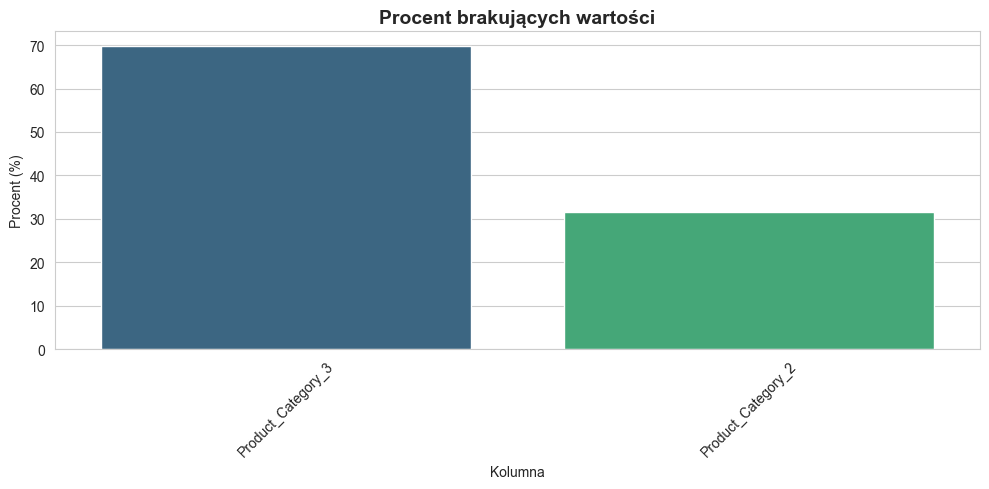

In [4]:
# Analiza brakujących wartości używając PySpark
from pyspark.sql.functions import col, count, when, isnan

# Oblicz brakujące wartości dla każdej kolumny
missing_data = []
total_count = train_df.count()

for column in train_df.columns:
    null_count = train_df.filter(col(column).isNull()).count()
    if null_count > 0:
        missing_data.append({
            'Kolumna': column,
            'Brakujące': null_count,
            'Procent': round((null_count / total_count) * 100, 2)
        })

# Konwertuj do Pandas dla wyświetlenia
if missing_data:
    missing_df = pd.DataFrame(missing_data).sort_values('Brakujące', ascending=False)
    print("Brakujące wartości w danych:")
    print(missing_df.to_string(index=False))
    
    # Wizualizacja brakujących wartości
    fig, ax = plt.subplots(figsize=(10, 5))
    sns.barplot(data=missing_df, x='Kolumna', y='Procent', ax=ax, palette='viridis')
    ax.set_title('Procent brakujących wartości', fontsize=14, fontweight='bold')
    ax.set_ylabel('Procent (%)')
    ax.set_xlabel('Kolumna')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("\nBrak brakujących wartości!")

## 4. Statystyki Opisowe

In [7]:
# Statystyki dla zmiennych numerycznych używając PySpark
print("Statystyki opisowe dla zmiennych numerycznych:")
train_df.describe().show()

# Szczegółowe statystyki dla zmiennej docelowej (Purchase) używając Spark SQL
purchase_stats = train_df.select(
    F.mean('Purchase').alias('mean'),
    F.expr('percentile_approx(Purchase, 0.5)').alias('median'),
    F.stddev('Purchase').alias('std'),
    F.min('Purchase').alias('min'),
    F.max('Purchase').alias('max')
).collect()[0]

print("\n" + "="*50)
print("Statystyki dla zmiennej docelowej (Purchase):")
print("="*50)
print(f"Średnia: ${purchase_stats['mean']:,.2f}")
print(f"Mediana: ${purchase_stats['median']:,.2f}")
print(f"Odchylenie std: ${purchase_stats['std']:,.2f}")
print(f"Min: ${purchase_stats['min']:,.2f}")
print(f"Max: ${purchase_stats['max']:,.2f}")

Statystyki opisowe dla zmiennych numerycznych:
+-------+------------------+----------+------+------+-----------------+-------------+--------------------------+-------------------+------------------+------------------+------------------+-----------------+
|summary|           User_ID|Product_ID|Gender|   Age|       Occupation|City_Category|Stay_In_Current_City_Years|     Marital_Status|Product_Category_1|Product_Category_2|Product_Category_3|         Purchase|
+-------+------------------+----------+------+------+-----------------+-------------+--------------------------+-------------------+------------------+------------------+------------------+-----------------+
|  count|            550068|    550068|550068|550068|           550068|       550068|                    550068|             550068|            550068|            376430|            166821|           550068|
|   mean|1003028.8424013031|      NULL|  NULL|  NULL|8.076706879876669|         NULL|         1.468494139793958|0.4096529

## 5. Analiza Zmiennych Kategorycznych

In [8]:
# Zmienne kategoryczne używając PySpark
categorical_cols = ['Gender', 'Age', 'Occupation', 'City_Category', 
                    'Stay_In_Current_City_Years', 'Marital_Status']

for col_name in categorical_cols:
    print(f"\n{col_name}:")
    # Grupowanie i zliczanie używając Spark
    value_counts = train_df.groupBy(col_name).count().orderBy(col_name)
    value_counts.show()
    
    # Liczba unikalnych wartości
    unique_count = train_df.select(col_name).distinct().count()
    print(f"Unikalne wartości: {unique_count}")


Gender:
+------+------+
|Gender| count|
+------+------+
|     F|135809|
|     M|414259|
+------+------+

Unikalne wartości: 2

Age:
+-----+------+
|  Age| count|
+-----+------+
| 0-17| 15102|
|18-25| 99660|
|26-35|219587|
|36-45|110013|
|46-50| 45701|
|51-55| 38501|
|  55+| 21504|
+-----+------+

Unikalne wartości: 7

Occupation:
+----------+-----+
|Occupation|count|
+----------+-----+
|         0|69638|
|         1|47426|
|         2|26588|
|         3|17650|
|         4|72308|
|         5|12177|
|         6|20355|
|         7|59133|
|         8| 1546|
|         9| 6291|
|        10|12930|
|        11|11586|
|        12|31179|
|        13| 7728|
|        14|27309|
|        15|12165|
|        16|25371|
|        17|40043|
|        18| 6622|
|        19| 8461|
+----------+-----+
only showing top 20 rows

Unikalne wartości: 21

City_Category:
+-------------+------+
|City_Category| count|
+-------------+------+
|            A|147720|
|            B|231173|
|            C|171175|
+--------

## 6. Wizualizacje - Rozkład Zmiennej Docelowej

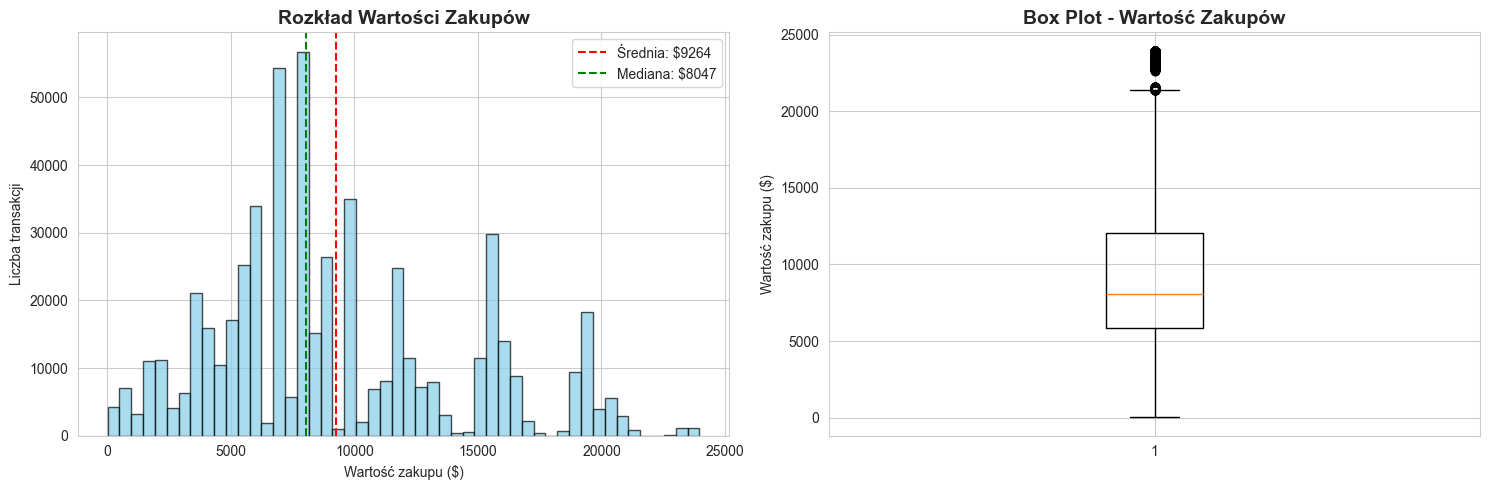

Liczba obserwacji: 550,068


In [9]:
# Rozkład wartości zakupów
# Konwertuj kolumnę Purchase do Pandas dla wizualizacji
purchase_data = train_df.select('Purchase').toPandas()

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histogram
axes[0].hist(purchase_data['Purchase'], bins=50, edgecolor='black', alpha=0.7, color='skyblue')
axes[0].set_title('Rozkład Wartości Zakupów', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Wartość zakupu ($)')
axes[0].set_ylabel('Liczba transakcji')
axes[0].axvline(purchase_data['Purchase'].mean(), color='red', linestyle='--', 
                label=f'Średnia: ${purchase_data["Purchase"].mean():.0f}')
axes[0].axvline(purchase_data['Purchase'].median(), color='green', linestyle='--', 
                label=f'Mediana: ${purchase_data["Purchase"].median():.0f}')
axes[0].legend()

# Box plot
axes[1].boxplot(purchase_data['Purchase'], vert=True)
axes[1].set_title('Box Plot - Wartość Zakupów', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Wartość zakupu ($)')

plt.tight_layout()
plt.show()

print(f"Liczba obserwacji: {len(purchase_data):,}")

## 7. Analiza według Płci

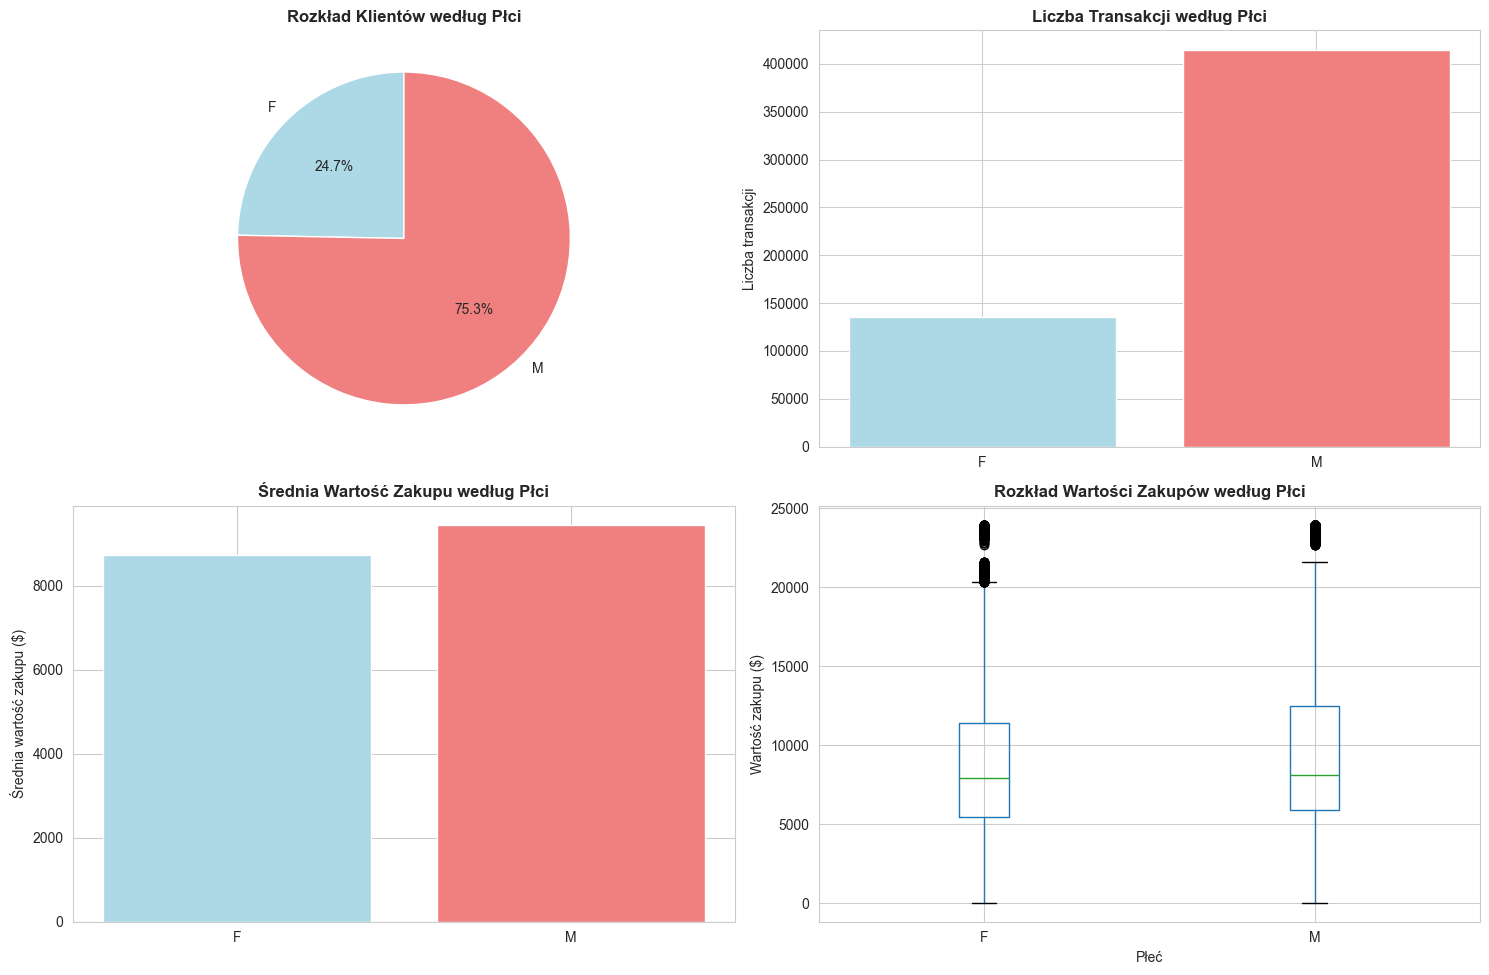

Statystyki według płci:
+------+------+-----------------+------+-----------------+
|Gender| count|             mean|median|              std|
+------+------+-----------------+------+-----------------+
|     F|135809|8734.565765155476|  7914|4767.233289291458|
|     M|414259|9437.526040472265|  8098|5092.186209777959|
+------+------+-----------------+------+-----------------+



In [10]:
# Analiza według płci używając PySpark
# Agregacje w Spark
gender_counts = train_df.groupBy('Gender').count().toPandas().set_index('Gender')['count']
gender_purchase = train_df.groupBy('Gender').agg(F.mean('Purchase').alias('avg_purchase')).toPandas()

# Pobierz dane do wizualizacji
gender_data = train_df.select('Gender', 'Purchase').toPandas()

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Liczba klientów według płci
axes[0, 0].pie(gender_counts.values, labels=gender_counts.index, autopct='%1.1f%%', 
               startangle=90, colors=['lightblue', 'lightcoral'])
axes[0, 0].set_title('Rozkład Klientów według Płci', fontsize=12, fontweight='bold')

# Liczba transakcji według płci
axes[0, 1].bar(gender_counts.index, gender_counts.values, color=['lightblue', 'lightcoral'])
axes[0, 1].set_title('Liczba Transakcji według Płci', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Liczba transakcji')

# Średnia wartość zakupu według płci
axes[1, 0].bar(gender_purchase['Gender'], gender_purchase['avg_purchase'], 
               color=['lightblue', 'lightcoral'])
axes[1, 0].set_title('Średnia Wartość Zakupu według Płci', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Średnia wartość zakupu ($)')

# Box plot - zakupy według płci
gender_data.boxplot(column='Purchase', by='Gender', ax=axes[1, 1])
axes[1, 1].set_title('Rozkład Wartości Zakupów według Płci', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Płeć')
axes[1, 1].set_ylabel('Wartość zakupu ($)')
plt.suptitle('')

plt.tight_layout()
plt.show()

# Statystyki używając Spark
print("Statystyki według płci:")
gender_stats = train_df.groupBy('Gender').agg(
    F.count('Purchase').alias('count'),
    F.mean('Purchase').alias('mean'),
    F.expr('percentile_approx(Purchase, 0.5)').alias('median'),
    F.stddev('Purchase').alias('std')
)
gender_stats.show()

## 8. Analiza według Wieku

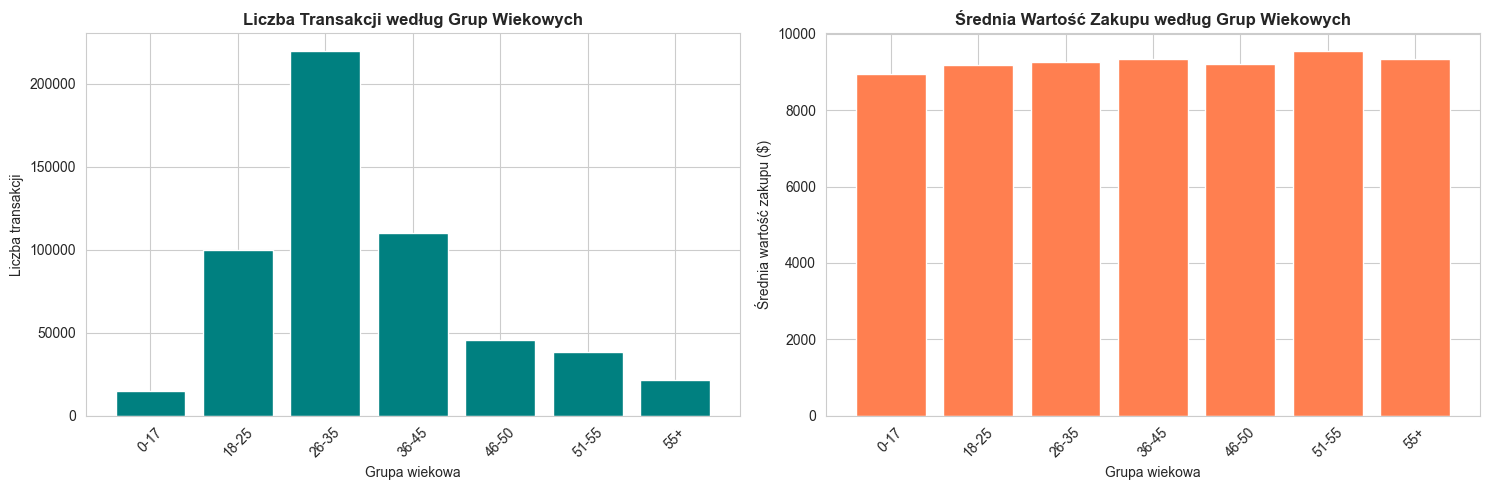

Statystyki według wieku:
+-----+------+-----------------+------+-----------------+
|  Age| count|             mean|median|              std|
+-----+------+-----------------+------+-----------------+
| 0-17| 15102|8933.464640444974|  7986|5111.114046002769|
|18-25| 99660|9169.663606261289|  8027|5034.321997176584|
|26-35|219587|9252.690632869888|  8030| 5010.52730300295|
|36-45|110013|9331.350694917874|  8061|5022.923879204662|
|46-50| 45701|9208.625697468327|  8036|4967.216367142938|
|51-55| 38501|9534.808030960236|  8130|5087.368079602136|
|  55+| 21504|9336.280459449405|  8105|5011.493995603461|
+-----+------+-----------------+------+-----------------+



In [11]:
# Analiza według wieku używając PySpark
# Agregacje w Spark
age_counts = train_df.groupBy('Age').count().orderBy('Age').toPandas()
age_purchase = train_df.groupBy('Age').agg(F.mean('Purchase').alias('avg_purchase')).orderBy('Age').toPandas()

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Liczba transakcji według wieku
axes[0].bar(range(len(age_counts)), age_counts['count'], color='teal')
axes[0].set_xticks(range(len(age_counts)))
axes[0].set_xticklabels(age_counts['Age'], rotation=45)
axes[0].set_title('Liczba Transakcji według Grup Wiekowych', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Grupa wiekowa')
axes[0].set_ylabel('Liczba transakcji')

# Średnia wartość zakupu według wieku
axes[1].bar(range(len(age_purchase)), age_purchase['avg_purchase'], color='coral')
axes[1].set_xticks(range(len(age_purchase)))
axes[1].set_xticklabels(age_purchase['Age'], rotation=45)
axes[1].set_title('Średnia Wartość Zakupu według Grup Wiekowych', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Grupa wiekowa')
axes[1].set_ylabel('Średnia wartość zakupu ($)')

plt.tight_layout()
plt.show()

# Statystyki używając Spark
print("Statystyki według wieku:")
age_stats = train_df.groupBy('Age').agg(
    F.count('Purchase').alias('count'),
    F.mean('Purchase').alias('mean'),
    F.expr('percentile_approx(Purchase, 0.5)').alias('median'),
    F.stddev('Purchase').alias('std')
).orderBy('Age')
age_stats.show()

## 9. Analiza według Miasta i Stanu Cywilnego

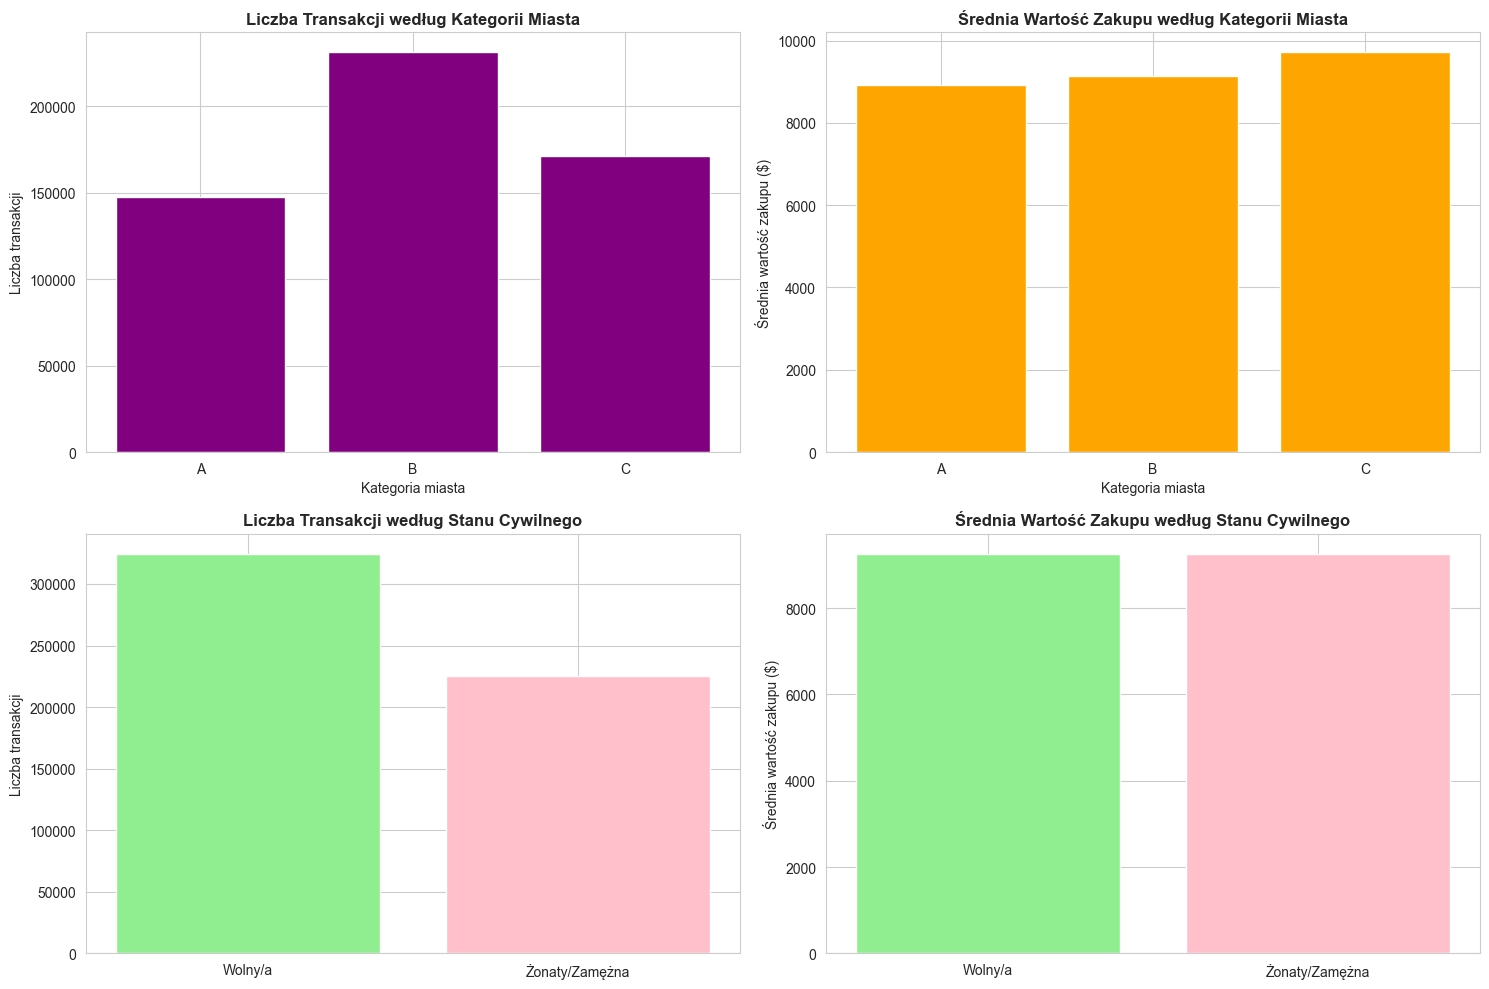

Statystyki według kategorii miasta:
+-------------+------+-----------------+------+
|City_Category| count|             mean|median|
+-------------+------+-----------------+------+
|            A|147720|8911.939216084484|  7931|
|            B|231173|9151.300562781986|  8004|
|            C|171175| 9719.92099313568|  8584|
+-------------+------+-----------------+------+



In [12]:
# Analiza według miasta i stanu cywilnego używając PySpark
# Agregacje w Spark
city_counts = train_df.groupBy('City_Category').count().orderBy('City_Category').toPandas()
city_purchase = train_df.groupBy('City_Category').agg(F.mean('Purchase').alias('avg_purchase')).orderBy('City_Category').toPandas()
marital_counts = train_df.groupBy('Marital_Status').count().orderBy('Marital_Status').toPandas()
marital_purchase = train_df.groupBy('Marital_Status').agg(F.mean('Purchase').alias('avg_purchase')).orderBy('Marital_Status').toPandas()

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Kategoria miasta - liczba transakcji
axes[0, 0].bar(city_counts['City_Category'], city_counts['count'], color='purple')
axes[0, 0].set_title('Liczba Transakcji według Kategorii Miasta', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Kategoria miasta')
axes[0, 0].set_ylabel('Liczba transakcji')

# Kategoria miasta - średnia wartość zakupu
axes[0, 1].bar(city_purchase['City_Category'], city_purchase['avg_purchase'], color='orange')
axes[0, 1].set_title('Średnia Wartość Zakupu według Kategorii Miasta', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Kategoria miasta')
axes[0, 1].set_ylabel('Średnia wartość zakupu ($)')

# Stan cywilny - liczba transakcji
axes[1, 0].bar(['Wolny/a', 'Żonaty/Zamężna'], marital_counts['count'], color=['lightgreen', 'pink'])
axes[1, 0].set_title('Liczba Transakcji według Stanu Cywilnego', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Liczba transakcji')

# Stan cywilny - średnia wartość zakupu
axes[1, 1].bar(['Wolny/a', 'Żonaty/Zamężna'], marital_purchase['avg_purchase'], color=['lightgreen', 'pink'])
axes[1, 1].set_title('Średnia Wartość Zakupu według Stanu Cywilnego', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Średnia wartość zakupu ($)')

plt.tight_layout()
plt.show()

# Statystyki używając Spark
print("Statystyki według kategorii miasta:")
city_stats = train_df.groupBy('City_Category').agg(
    F.count('Purchase').alias('count'),
    F.mean('Purchase').alias('mean'),
    F.expr('percentile_approx(Purchase, 0.5)').alias('median')
).orderBy('City_Category')
city_stats.show()

## 10. Analiza Kategorii Produktów

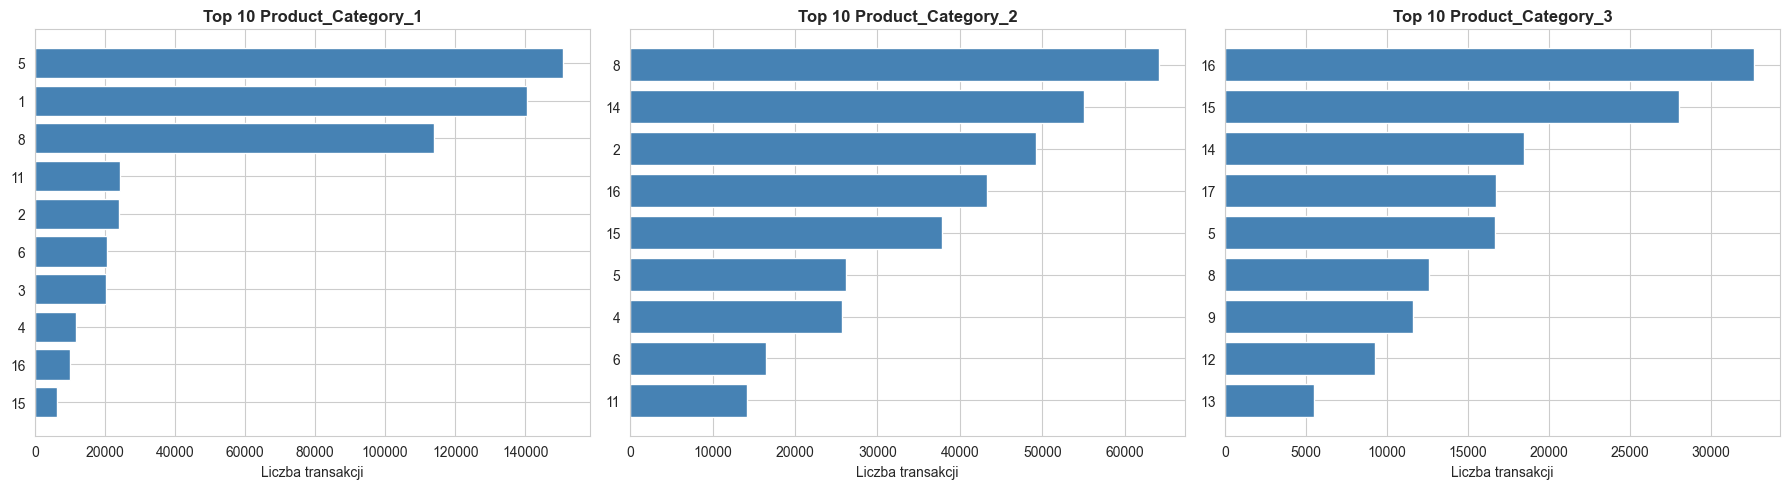

Najpopularniejsze kategorie (Product_Category_1):
+------------------+------+
|Product_Category_1| count|
+------------------+------+
|                 5|150933|
|                 1|140378|
|                 8|113925|
|                11| 24287|
|                 2| 23864|
|                 6| 20466|
|                 3| 20213|
|                 4| 11753|
|                16|  9828|
|                15|  6290|
+------------------+------+



In [13]:
# Analiza kategorii produktów używając PySpark
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, col_name in enumerate(['Product_Category_1', 'Product_Category_2', 'Product_Category_3']):
    # Top 10 kategorii używając Spark
    top_categories = train_df.groupBy(col_name) \
        .count() \
        .orderBy(F.desc('count')) \
        .limit(10) \
        .toPandas()
    
    # Filtruj null values
    top_categories = top_categories[top_categories[col_name].notna()]
    
    axes[idx].barh(range(len(top_categories)), top_categories['count'], color='steelblue')
    axes[idx].set_yticks(range(len(top_categories)))
    axes[idx].set_yticklabels(top_categories[col_name].astype(int))
    axes[idx].set_title(f'Top 10 {col_name}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Liczba transakcji')
    axes[idx].invert_yaxis()

plt.tight_layout()
plt.show()

# Najpopularniejsze kategorie produktów
print("Najpopularniejsze kategorie (Product_Category_1):")
top_cat1 = train_df.groupBy('Product_Category_1') \
    .count() \
    .orderBy(F.desc('count')) \
    .limit(10)
top_cat1.show()

## 11. Analiza Korelacji

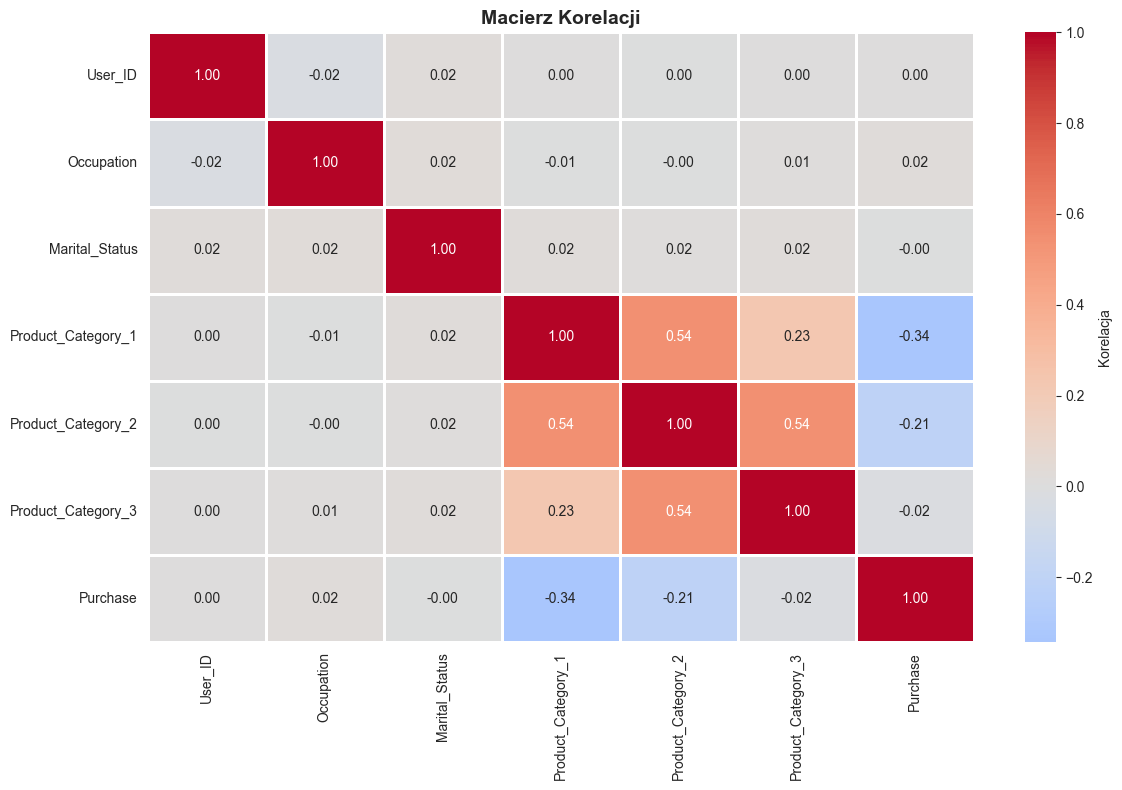

Korelacja zmiennych z wartością zakupu (Purchase):
Purchase              1.000000
Occupation            0.020833
User_ID               0.004716
Marital_Status       -0.000463
Product_Category_3   -0.022006
Product_Category_2   -0.209918
Product_Category_1   -0.343703
Name: Purchase, dtype: float64

Korelacja obliczona w PySpark:
Occupation <-> Purchase: 0.0208
Marital_Status <-> Purchase: -0.0005
Product_Category_1 <-> Purchase: -0.3437


In [14]:
# Macierz korelacji dla zmiennych numerycznych
# Konwertuj do Pandas dla obliczenia korelacji (dla małych podzbiorów danych)
# Alternatywnie można użyć pyspark.ml.stat.Correlation

numeric_cols = ['User_ID', 'Occupation', 'Marital_Status', 
                'Product_Category_1', 'Product_Category_2', 'Product_Category_3', 'Purchase']

# Pobierz dane numeryczne do Pandas (dla korelacji)
numeric_data = train_df.select(numeric_cols).toPandas()
correlation_matrix = numeric_data.corr()

# Heatmapa
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            fmt='.2f', linewidths=1, cbar_kws={'label': 'Korelacja'})
plt.title('Macierz Korelacji', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Korelacja z Purchase
print("Korelacja zmiennych z wartością zakupu (Purchase):")
print(correlation_matrix['Purchase'].sort_values(ascending=False))

# Alternatywnie: Oblicz korelację bezpośrednio w Spark
print("\n" + "="*50)
print("Korelacja obliczona w PySpark:")
print("="*50)
for col_name in ['Occupation', 'Marital_Status', 'Product_Category_1']:
    corr = train_df.stat.corr(col_name, 'Purchase')
    print(f"{col_name} <-> Purchase: {corr:.4f}")

## 12. Wizualizacje Interaktywne (Plotly)

In [15]:
# Analiza według płci i wieku - interaktywna
# Agregacja w Spark
gender_age_purchase = train_df.groupBy('Gender', 'Age').agg(
    F.mean('Purchase').alias('mean'),
    F.count('Purchase').alias('count')
).orderBy('Age').toPandas()

fig = px.bar(gender_age_purchase, 
             x='Age', 
             y='mean', 
             color='Gender',
             barmode='group',
             title='Średnia Wartość Zakupu według Płci i Wieku',
             labels={'mean': 'Średnia wartość zakupu ($)', 'Age': 'Grupa wiekowa'},
             hover_data=['count'])

fig.update_layout(height=500, showlegend=True)
fig.show()

## 13. Analiza Top Klientów i Produktów

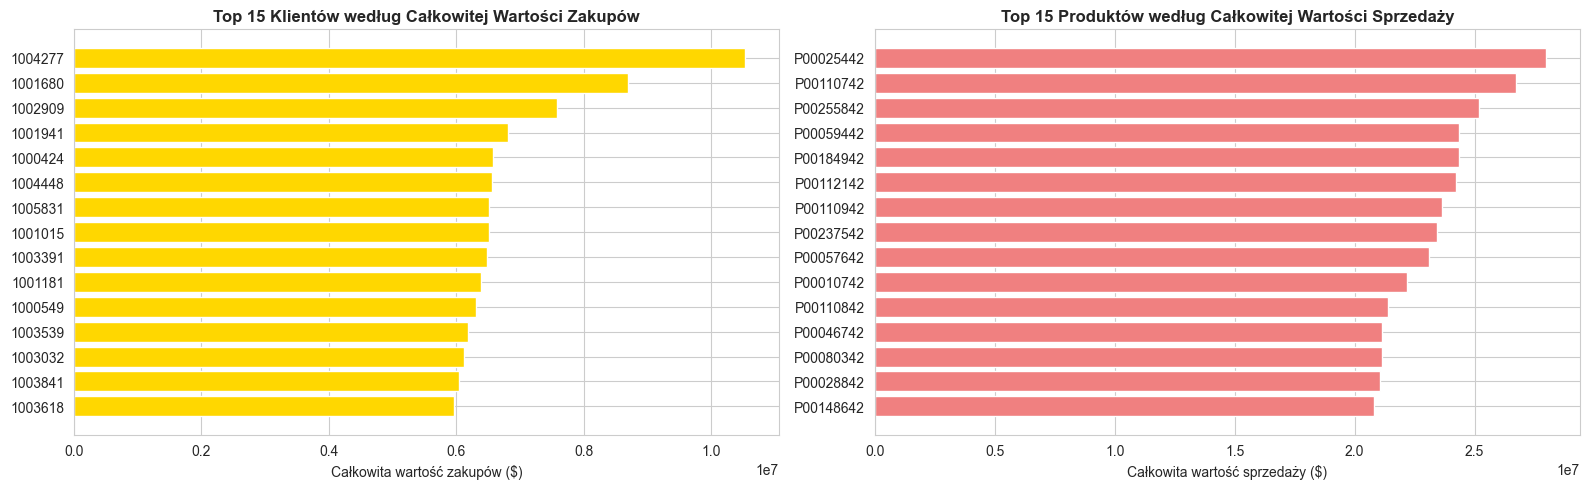


Liczba unikalnych klientów: 5,891
Liczba unikalnych produktów: 3,631


In [16]:
# Top klienci według całkowitej wartości zakupów używając PySpark
top_customers = train_df.groupBy('User_ID').agg(
    F.sum('Purchase').alias('Total_Purchase'),
    F.count('Purchase').alias('Num_Transactions'),
    F.mean('Purchase').alias('Avg_Purchase')
).orderBy(F.desc('Total_Purchase')).limit(15).toPandas()

# Top produkty
top_products = train_df.groupBy('Product_ID').agg(
    F.sum('Purchase').alias('total_sales'),
    F.count('Purchase').alias('count')
).orderBy(F.desc('total_sales')).limit(15).toPandas()

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Top klienci według wartości
axes[0].barh(range(len(top_customers)), top_customers['Total_Purchase'].values, color='gold')
axes[0].set_yticks(range(len(top_customers)))
axes[0].set_yticklabels(top_customers['User_ID'].values)
axes[0].set_title('Top 15 Klientów według Całkowitej Wartości Zakupów', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Całkowita wartość zakupów ($)')
axes[0].invert_yaxis()

# Top produkty
axes[1].barh(range(len(top_products)), top_products['total_sales'].values, color='lightcoral')
axes[1].set_yticks(range(len(top_products)))
axes[1].set_yticklabels(top_products['Product_ID'].values)
axes[1].set_title('Top 15 Produktów według Całkowitej Wartości Sprzedaży', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Całkowita wartość sprzedaży ($)')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

# Statystyki używając Spark
unique_customers = train_df.select('User_ID').distinct().count()
unique_products = train_df.select('Product_ID').distinct().count()

print(f"\nLiczba unikalnych klientów: {unique_customers:,}")
print(f"Liczba unikalnych produktów: {unique_products:,}")

## 14. Kluczowe Wnioski

Na podstawie przeprowadzonej analizy eksploracyjnej możemy wyciągnąć następujące wnioski:

### Ogólne statystyki:
- Dataset zawiera dane transakcyjne z Black Friday
- Każdy wiersz reprezentuje pojedynczą transakcję zakupu
- Zmienna docelowa to `Purchase` - wartość zakupu w dolarach

### Profil klientów:
- **Płeć**: Mężczyźni stanowią większość klientów i dokonują więcej transakcji
- **Wiek**: Największa grupa klientów to osoby w wieku 26-35 lat
- **Stan cywilny**: Zarówno osoby wolne jak i w związkach dokonują podobnych zakupów
- **Lokalizacja**: Kategoria B miasta ma najwięcej transakcji

### Zachowania zakupowe:
- Średnia wartość zakupu jest dość stabilna między różnymi grupami demograficznymi
- Kategoria produktów 1, 5 i 8 są najpopularniejsze
- Niektórzy klienci dokonują wielokrotnych zakupów (lojalni klienci)

### Brakujące dane:
- Product_Category_2 i Product_Category_3 mają znaczną liczbę brakujących wartości
- To sugeruje, że wiele produktów należy tylko do jednej głównej kategorii

### Rekomendacje dla modelowania:
1. Należy zająć się brakującymi wartościami w kategoriach produktów
2. Warto rozważyć feature engineering (np. łączne wydatki klienta)
3. Kategorie wiekowe mogą być ważnym predyktorem
4. Rozważyć agregację danych na poziomie klienta

## 16. Podsumowanie Analizy

In [17]:
# Podsumowanie analizy EDA
print("="*60)
print("PODSUMOWANIE ANALIZY EKSPLORACYJNEJ (EDA)")
print("="*60)
print("\n✓ Analiza przeprowadzona używając Apache Spark (PySpark)")
print("✓ Dane załadowane i przetworzone w formacie Spark DataFrame")
print("✓ Agregacje i transformacje wykonane w Spark SQL")
print("✓ Wizualizacje utworzone używając Matplotlib, Seaborn i Plotly")
print("\nKolejne kroki projektu:")
print("1. Feature Engineering - tworzenie nowych cech (Faza 2)")
print("2. ETL Pipeline w PySpark (Faza 2)")
print("3. Budowa modeli ML używając Spark MLlib (Faza 3)")
print("4. Streaming z Kafka + Spark Streaming (Faza 4)")
print("5. System rekomendacji ALS (Faza 5)")
print("="*60)

# Opcjonalnie: Zatrzymaj sesję Spark
# Odkomentuj poniższą linię, jeśli chcesz zakończyć sesję
# SparkConfig.stop_spark_session(spark)

PODSUMOWANIE ANALIZY EKSPLORACYJNEJ (EDA)

✓ Analiza przeprowadzona używając Apache Spark (PySpark)
✓ Dane załadowane i przetworzone w formacie Spark DataFrame
✓ Agregacje i transformacje wykonane w Spark SQL
✓ Wizualizacje utworzone używając Matplotlib, Seaborn i Plotly

Kolejne kroki projektu:
1. Feature Engineering - tworzenie nowych cech (Faza 2)
2. ETL Pipeline w PySpark (Faza 2)
3. Budowa modeli ML używając Spark MLlib (Faza 3)
4. Streaming z Kafka + Spark Streaming (Faza 4)
5. System rekomendacji ALS (Faza 5)
